<a href="https://colab.research.google.com/github/santhiravuri/generative-ai-internship/blob/main/day21_MINI_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision matplotlib seaborn scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

✅ Step 1: Build a Basic Autoencoder (AE)

In [34]:
# 1.1 Define AE Architecture
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out.view(-1, 1, 28, 28)


In [35]:
# 1.2 Train the Autoencoder
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_data  = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=128, shuffle=False)

ae = Autoencoder().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(ae.parameters(), lr=1e-3)

ae_losses = []
for epoch in range(10):
    ae.train()
    running_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        out = ae(x)
        loss = criterion(out, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    ae_losses.append(running_loss / len(train_loader))
    print(f"Epoch {epoch+1}, AE Loss: {ae_losses[-1]:.4f}")


Epoch 1, AE Loss: 0.2080
Epoch 2, AE Loss: 0.1255
Epoch 3, AE Loss: 0.1077
Epoch 4, AE Loss: 0.0998
Epoch 5, AE Loss: 0.0957
Epoch 6, AE Loss: 0.0928
Epoch 7, AE Loss: 0.0904
Epoch 8, AE Loss: 0.0884
Epoch 9, AE Loss: 0.0870
Epoch 10, AE Loss: 0.0860


✅ Step 2: Visualize Latent Space with PCA/t-SNE

In [36]:
# 2.1 Extract Encoded Representations
ae.eval()
latent_vectors = []
labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        z = ae.encoder(x)
        latent_vectors.append(z.cpu())
        labels.append(y)

Z = torch.cat(latent_vectors).numpy()
Y = torch.cat(labels).numpy()


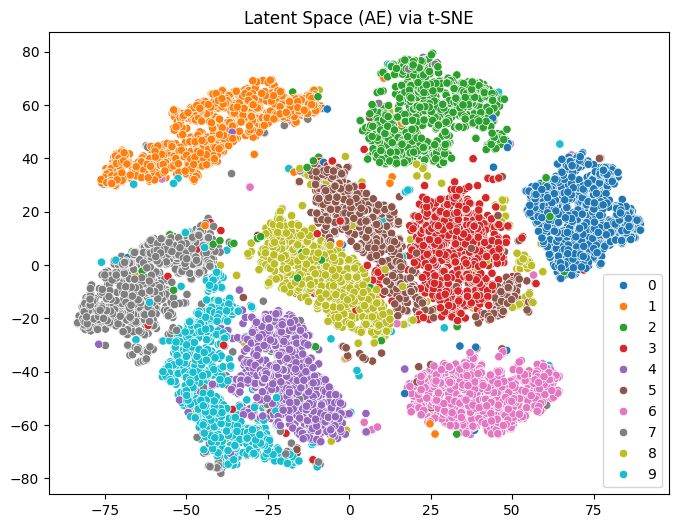

In [37]:
#2.2 Concatenate and Visualize
tsne = TSNE(n_components=2, random_state=0)
Z_2D = tsne.fit_transform(Z)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=Z_2D[:,0], y=Z_2D[:,1], hue=Y, palette='tab10', legend='full')
plt.title("Latent Space (AE) via t-SNE")
plt.savefig("latent_plot.png")
plt.show()


✅ Step 3: Replace AE with Variational Autoencoder (VAE)

In [38]:
#3.1 Define VAE Architecture
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128, 32)
        self.fc_logvar = nn.Linear(128, 32)

        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        out = self.decoder(z)
        return out.view(-1, 1, 28, 28), mu, logvar


In [39]:
#3.2 Define VAE Loss
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [45]:
#3.3 Train the VAE
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

vae_losses = []
for epoch in range(20):
    vae.train()
    epoch_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        recon, mu, logvar = vae(x)
        loss = vae_loss(recon, x, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    vae_losses.append(epoch_loss / len(train_loader.dataset))
    print(f"Epoch {epoch+1}, VAE Loss: {vae_losses[-1]:.4f}")


Epoch 1, VAE Loss: 195.0999
Epoch 2, VAE Loss: 142.8735
Epoch 3, VAE Loss: 130.4972
Epoch 4, VAE Loss: 124.0893
Epoch 5, VAE Loss: 120.0121
Epoch 6, VAE Loss: 117.1516
Epoch 7, VAE Loss: 115.2255
Epoch 8, VAE Loss: 113.9665
Epoch 9, VAE Loss: 112.9671
Epoch 10, VAE Loss: 112.1977
Epoch 11, VAE Loss: 111.6046
Epoch 12, VAE Loss: 111.1909
Epoch 13, VAE Loss: 110.7462
Epoch 14, VAE Loss: 110.4797
Epoch 15, VAE Loss: 110.1925
Epoch 16, VAE Loss: 109.9916
Epoch 17, VAE Loss: 109.7295
Epoch 18, VAE Loss: 109.5525
Epoch 19, VAE Loss: 109.3042
Epoch 20, VAE Loss: 109.2329


✅ Step 4: Compare Reconstructions (AE vs VAE)

In [46]:
# 4.1 Pass Sample Inputs Through Both Models
test_iter = iter(test_loader)
images, _ = next(test_iter)
images = images.to(device)

ae.eval()
vae.eval()

with torch.no_grad():
    ae_output = ae(images).cpu()
    vae_output, _, _ = vae(images)
    vae_output = vae_output.cpu()
    images = images.cpu()


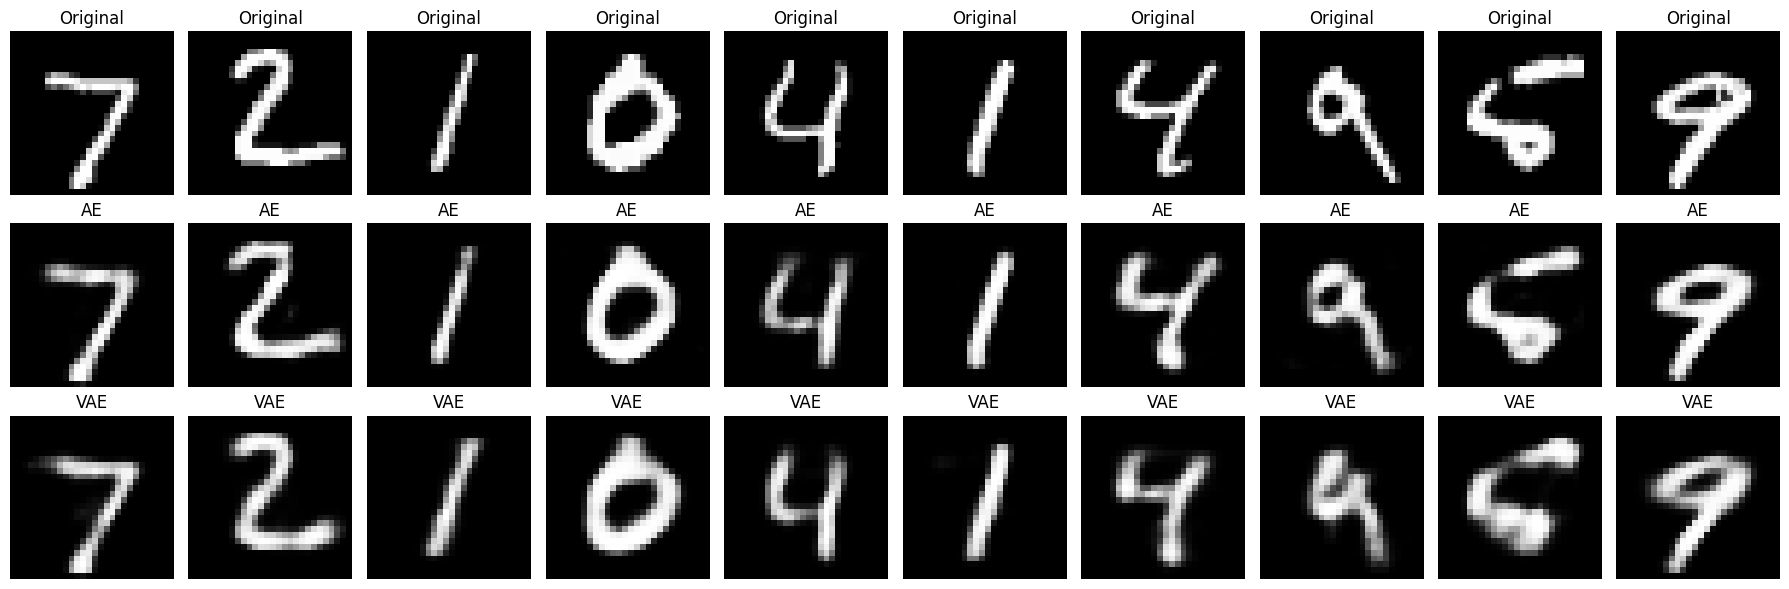

In [47]:
#4.2 Plot Original vs Reconstructions
def show_images(original, ae_rec, vae_rec, n=10):
    plt.figure(figsize=(18, 6))
    for i in range(n):
        plt.subplot(3, n, i+1)
        plt.imshow(original[i][0], cmap='gray')
        plt.title("Original")
        plt.axis('off')

        plt.subplot(3, n, i+1+n)
        plt.imshow(ae_rec[i][0], cmap='gray')
        plt.title("AE")
        plt.axis('off')

        plt.subplot(3, n, i+1+2*n)
        plt.imshow(vae_rec[i][0], cmap='gray')
        plt.title("VAE")
        plt.axis('off')
    plt.tight_layout()
    plt.savefig("reconstructions.png")
    plt.show()

show_images(images, ae_output, vae_output)


✅ Step 5: Perform Latent Vector Arithmetic

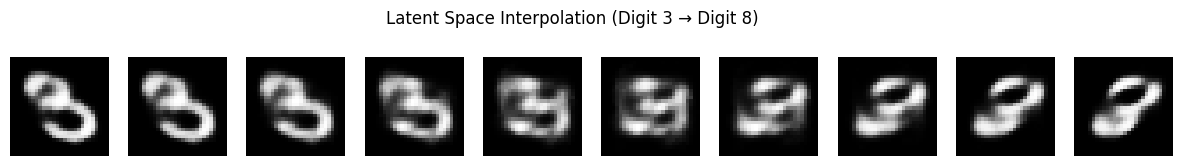

In [43]:
#Morph Digits via Latent Interpolation
# Get digits 3 and 8
chosen = []
targets = [3, 8]
for x, y in test_loader:
    for i in range(len(y)):
        if y[i].item() == targets[0] and len(chosen) == 0:
            chosen.append(x[i].unsqueeze(0))
        elif y[i].item() == targets[1] and len(chosen) == 1:
            chosen.append(x[i].unsqueeze(0))
    if len(chosen) == 2:
        break

img1, img2 = chosen[0].to(device), chosen[1].to(device)

with torch.no_grad():
    z1 = vae.fc_mu(vae.encoder(img1.view(1, -1)))
    z2 = vae.fc_mu(vae.encoder(img2.view(1, -1)))

interpolated = []
steps = 10
for alpha in np.linspace(0, 1, steps):
    z = (1 - alpha) * z1 + alpha * z2
    out = vae.decoder(z).view(1, 1, 28, 28)
    interpolated.append(out.squeeze(0).cpu().detach())

# Plot Interpolation
plt.figure(figsize=(15, 2))
for i in range(steps):
    plt.subplot(1, steps, i + 1)
    plt.imshow(interpolated[i][0], cmap='gray')
    plt.axis('off')
plt.suptitle("Latent Space Interpolation (Digit 3 → Digit 8)")
plt.savefig("latent_interpolation.png")
plt.show()

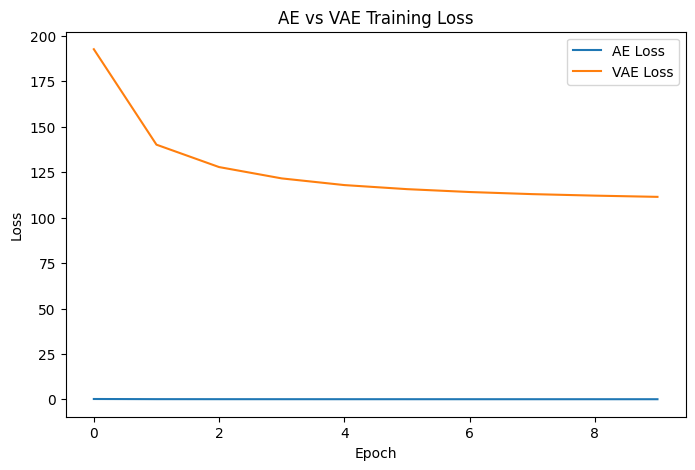

In [44]:
#Plot Loss Curves for AE and VAE
plt.figure(figsize=(8, 5))
plt.plot(ae_losses, label="AE Loss")
plt.plot(vae_losses, label="VAE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("AE vs VAE Training Loss")
plt.legend()
plt.savefig("loss_curves.png")
plt.show()